# Pulling and Visualizing Wealth & Poverty Data

"Despite decades of declining poverty rates, an estimated 8.4% of the global population remains in extreme poverty as of 2019, and progress has slowed in recent years [1]. But data on poverty remain surprisingly sparse, hampering efforts at monitoring local progress, targeting aid to those who need it, and evaluating the effectiveness of antipoverty programs [2]. Previous works [3,4] have demonstrated using computer vision on satellite images and street-level images to predict economic livelihood." [5]

In this notebook, we will pull a 2021 benchmark dataset from the Stanford Sustainability and AI Lab called "SustainBench". This dataset contains a variety of datasets related to sustainability, including datasets related to poverty and wealth mapping. More info on it can be found on the [project website](https://sustainlab-group.github.io/sustainbench/), the [GitHub repo](https://github.com/sustainlab-group/sustainbench), or the [arXiv paper](https://arxiv.org/abs/2111.04724). The data comes from surveys collected by the [Demographic and Health Surveys (DHS) Program](https://dhsprogram.com/) from USAID (RIP 😢). Nationally represenative surveys are conducted every few years in dozens of low- and middle-income countries (LMICs) around the world. Surveyors will go out to urban neigborhoods or rural communities and survey a few dozen random households within that "cluster". The anonymized household level data is geotagged with the coordinates of the cluster with a jitter to further protect privacy. The jitter is within a 2km radius for urban clusters, and a 5km radius for rural clusters. We will focus on Task 1A from SustainBench, mapping wealth and poverty spatially. SustainBench has made our lives easier by collating this data for 80k+ clusters and making it publicly avaiable, but you can request the original and latest household-level data directly from the [DHS on their website](https://dhsprogram.com/data/available-datasets.cfm), it takes just a couple of days to get approved.

![sustainbench](https://sustainlab-group.github.io/sustainbench/assets/images/sdg1_summary.png)

In subsequent notebooks, we then will pull in geospatial foundation models such as [SatCLIP](https://github.com/microsoft/satclip) and [MOSAIKS](https://www.mosaiks.org/). We will then use these models to extract features from the poverty and wealth mapping dataset, and then train a linear classifier on top of these features to predict the poverty and wealth labels. We will then evaluate the performance of each model on the test set.

## Learning Outcomes
1. Identify benchmark datasets for a task of interest
2. Pull in the relevant data
3. Visualize it

### References

[1] United Nations Department of Economic and Social Affairs. The Sustainable Development Goals Report 2021. The Sustainable Development Goals Report. United Nations, 2021 edition, 2021. ISBN 978-92-1-005608-3. doi: 10.18356/9789210056083. URL https://www.un-ilibrary.org/content/books/9789210056083.

[2] M. Burke, A. Driscoll, D. B. Lobell, and S. Ermon. Using satellite imagery to understand and promote sustainable development. Science, 371(6535), 2021. doi: 10.1126/science.448abe8628. URL https://www.science.org/doi/10.1126/science.abe8628.

[3] C. Yeh, A. Perez, A. Driscoll, G. Azzari, Z. Tang, D. Lobell, S. Ermon, and M. Burke. Using publicly available satellite imagery and deep learning to understand economic well-being in Africa. Nature Communications, 11(1), 5 2020. ISSN 2041-1723. doi: 10.1038/s41467-020-58916185-w. URL https://www.nature.com/articles/s41467-020-16185-w.

[4] J. Lee, D. Grosz, B. Uzkent, S. Zeng, M. Burke, D. Lobell, and S. Ermon. Predicting Livelihood Indicators from Community-Generated Street-Level Imagery. Proceedings of the AAAI Conference on Artificial Intelligence, 35(1):268–276, 5 2021. ISSN 2374-3468. URL https://ojs.aaai.org/index.php/AAAI/article/view/16101.

[5] C. Yeh, C. Meng, S. Wang, A. Driscoll, E. Rozi, P. Liu, J. Lee, M. Burke, D. Lobell, and S. Ermon, “SustainBench: Benchmarks for Monitoring the Sustainable Development Goals with Machine Learning,” in Thirty-fifth Conference on Neural Information Processing Systems, Datasets and Benchmarks Track (Round 2), Dec. 2021. [Online]. Available: https://openreview.net/forum?id=5HR3vCylqD.



## Environment Setup

In [13]:
# data reading and manipulation
import os
import numpy as np
import pandas as pd
import geopandas as gpd

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

print("imported")


imported


## Fetch Data
The dataset we'll fetch is described [here](https://sustainlab-group.github.io/sustainbench/docs/datasets/dhs.html) and hosted on Google Drive [here](https://drive.google.com/drive/folders/1tzWDfd4Y5MvJnJb-lHieOuD-aVcUqzcu?usp=sharing). I've uploaded it to Kaggle [here](https://www.kaggle.com/datasets/isaiahlg/dhs-labels-for-poverty-mapping-from-sustainbench/) and pulled it into this notebook under Inputs. 

## Read in and Visualize Dataset
Every good data scientists knows that you need to visualize your data to understand it.

In [14]:
# read in the csv file
# remove modify the path as needed
labels_path = ('data/dhs_final_labels.csv')
df = pd.read_csv(labels_path)

# now convert this regular dataframe into a nifty geopandas dataframe
# learn more about what a "geo" dataframe is here: https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe
# it's based on Python Shapely geometries: https://shapely.readthedocs.io/en/stable/geometry.html
# which is in turn based on C/C++ GEOS geometries: https://libgeos.org/usage/
# which is in turn based on the OGC Simple Features standard: https://en.wikipedia.org/wiki/Simple_Features
# which describes well-known text (WKT) representations of vector geometry: https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry
# fun!
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
gdf.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,n_sanitation,...,n_under5_mort,women_edu,women_bmi,n_women_edu,n_women_bmi,cluster_id,adm1fips,adm1dhs,urban,geometry
0,AL-2008-5#-00000001,AL,2008,40.822652,19.838321,18.0,2.430596,18.0,3.444444,18.0,...,6.0,9.500000,24.365000,18.0,18.0,1,NaN,9999,R,POINT (19.83832 40.82265)
1,AL-2008-5#-00000002,AL,2008,40.696846,20.007555,20.0,2.867678,20.0,4.700000,20.0,...,NaN,8.600000,23.104000,20.0,20.0,2,NaN,9999,R,POINT (20.00756 40.69685)
2,AL-2008-5#-00000003,AL,2008,40.750037,19.974262,18.0,2.909049,18.0,4.500000,18.0,...,NaN,9.666667,22.387778,18.0,18.0,3,NaN,9999,R,POINT (19.97426 40.75004)
3,AL-2008-5#-00000004,AL,2008,40.798931,19.863338,19.0,2.881122,19.0,4.947368,19.0,...,NaN,9.952381,27.084500,21.0,20.0,4,NaN,9999,R,POINT (19.86334 40.79893)
4,AL-2008-5#-00000005,AL,2008,40.746123,19.843885,19.0,2.546830,19.0,4.684211,19.0,...,6.0,8.937500,24.523125,16.0,16.0,5,NaN,9999,R,POINT (19.84388 40.74612)


Text(0.5, 1.0, 'Mean Asset Index Labels per DHS Cluster')

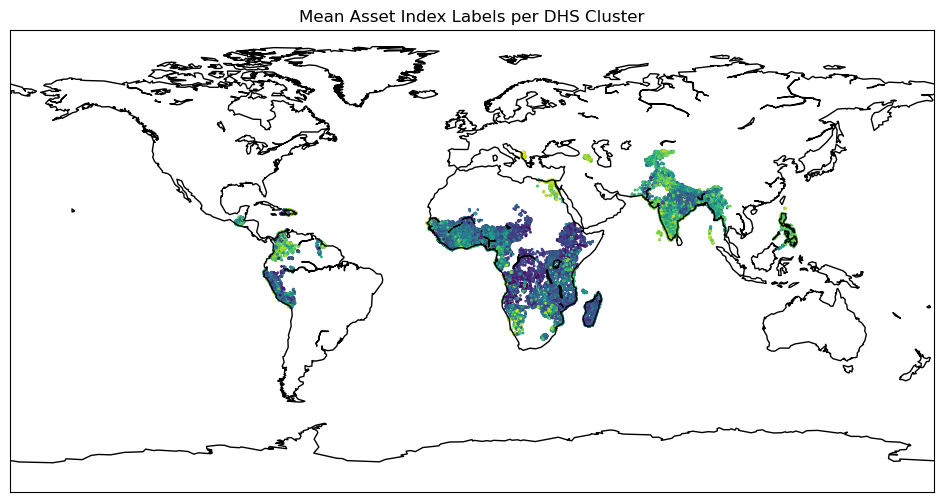

In [15]:
# I wanted visualize with lonboard from Development Seed built on top of deck.gl, but I couldn't get it working in Kaggle
# learn more about it at https://github.com/developmentseed/lonboard or in the documentation here https://developmentseed.org/lonboard/latest/
# Discussion about this issue here: https://github.com/developmentseed/lonboard/discussions/750
# bonus if you can figure out an interactive viz in Kaggle!
# instead we'll use a static visualization below:

fig, ax = plt.subplots(1, figsize=(12, 6))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(df['lon'], df['lat'], c=df['asset_index'], s=1)
ax.set_title('Mean Asset Index Labels per DHS Cluster')

## Assignment
1. Answer the following questions: What are some countries missing from this dataset? Why do you think DHS didn't include them? Could this lead to potential biases? 🤔
2. Visualize another variable from the labels file. Which one did you choose and why? How does the distribution compare to the asset index? Do you think there's a correlation between the two variables you chose.

## Bonus Assignment
Recreate the visualization above using an interactive geospatial Python visualization library (ie leaflet, carto, lonboard, etc etc..). Add your code below.

In [16]:
from lonboard import viz

In [21]:
import numpy as np
import matplotlib as mpl
from palettable.colorbrewer.diverging import BrBG_10  # diverging palette
from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap

# gdf: GeoDataFrame with Point geometry + column "asset_index"

vals = gdf["asset_index"].to_numpy(dtype=float)

# Diverging normalization: center at the median (use 0.0 if you want “diverge around zero”)
norm = mpl.colors.TwoSlopeNorm(
    vmin=np.nanmin(vals),
    vcenter=np.nanmedian(vals),
    vmax=np.nanmax(vals),
)
vals_0_1 = norm(vals)  # -> array in [0, 1]

layer = ScatterplotLayer.from_geopandas(gdf)
layer.radius_min_pixels = 2
layer.get_fill_color = apply_continuous_cmap(vals_0_1, BrBG_10, alpha=0.85)

m = Map(layer)
m


![image](wealth-data.png)

## Convert Notebook to HTML

In [22]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")

# export to HTML for webpage
import os
os.system('jupyter nbconvert --to html pt1-wealthdata.ipynb --HTMLExporter.theme=dark')

[NbConvertApp] Converting notebook pt1-wealthdata.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 510887 bytes to pt1-wealthdata.html


0